In [1]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 5.1 MB/s 


In [2]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 5.3 MB/s 


In [21]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib import cm
import time

import pyro

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

In [42]:
g_wavelengths, g_throughput, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, r_throughput, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, i_throughput, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, z_throughput, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)
wavelength_knots = np.loadtxt("l_knots_T21.txt")

In [5]:
colormap = plt.get_cmap('copper')

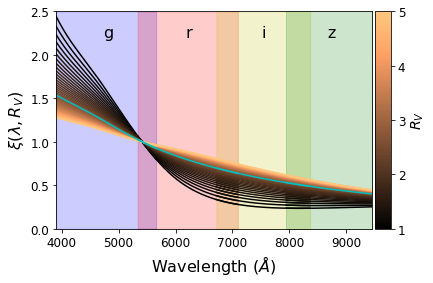

In [6]:
f = plt.figure()
for rv in np.linspace(1., 5.):
  color = colormap((rv-1) / 4)
  eg = extinction.fitzpatrick99(g_wavelengths, 1, rv)
  er = extinction.fitzpatrick99(r_wavelengths, 1, rv)
  ei = extinction.fitzpatrick99(i_wavelengths, 1, rv)
  ez = extinction.fitzpatrick99(z_wavelengths, 1, rv)

  plt.plot(g_wavelengths, eg, c = color)
  plt.plot(r_wavelengths, er, c = color)
  plt.plot(i_wavelengths, ei, c = color)
  plt.plot(z_wavelengths, ez, c = color)

rv = 2.61 # T21 value
color = 'c'
eg = extinction.fitzpatrick99(g_wavelengths, 1, rv)
er = extinction.fitzpatrick99(r_wavelengths, 1, rv)
ei = extinction.fitzpatrick99(i_wavelengths, 1, rv)
ez = extinction.fitzpatrick99(z_wavelengths, 1, rv)

plt.plot(g_wavelengths, eg, c = color)
plt.plot(r_wavelengths, er, c = color)
plt.plot(i_wavelengths, ei, c = color)
plt.plot(z_wavelengths, ez, c = color)

wavelength_colors = ['b', 'r', 'y', 'g']
wavelength_names = ['g', 'r', 'i','z']
for i, wavelengths in enumerate([g_wavelengths, r_wavelengths, i_wavelengths, z_wavelengths]):
  # plt.axvline(min(wavelengths), color = 'k')
  # plt.axvline(max(wavelengths), color = 'k')
  plt.fill_between(wavelengths, 2.5, color = wavelength_colors[i], alpha = 0.2)
  plt.text(np.mean(wavelengths),2.2, wavelength_names[i], fontsize = 16)

plt.xlim(min(g_wavelengths), max(z_wavelengths))
plt.ylim(0,2.5)
plt.ylabel("$\\xi(\lambda, R_V)$", fontsize = 16)
plt.xlabel("Wavelength ($\AA$)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

## https://stackoverflow.com/questions/41661409/how-to-generate-a-colorbar-for-manually-colored-plots-in-matplotlib
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=colormap, orientation='vertical')
plt.gcf().add_axes(ax_cb)


cb1.set_ticks([0, 0.25, 0.5, 0.75, 1.])
ax_cb.set_yticklabels([1,2,3,4,5], fontsize = 12)
cb1.set_label("$R_V$", fontsize = 14)

f.savefig("dust_extinction_plot.pdf", bbox_inches = 'tight')

In [7]:
def p(x, tau = 0.3, k = 25):
  Av = np.log(np.exp(k * x) + 1) / k
  return (1 / tau) * np.exp(-Av/tau) / (1 + np.exp(-k*x))

In [8]:
def p2(x, tau = 0.3, k = 25):
  Av = np.log(np.exp(k * x) + 1)
  return (1 / tau)  * np.exp(-Av/(k*tau)) / (1 + np.exp(-k*x))

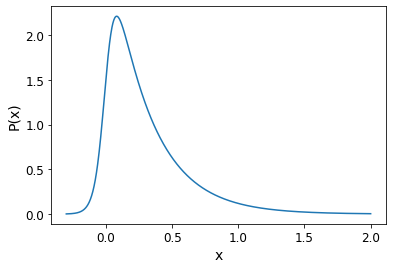

In [9]:
f = plt.figure()
x = np.linspace(-0.3,2, 1000)
plt.plot(x, p(x), c = 'tab:blue')
# plt.plot(x, p2(x))
plt.xlabel("x", fontsize = 14)
plt.ylabel("P(x)", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
f.savefig("softplus_pdf.pdf", bbox_inches = 'tight')

In [10]:
np.trapz(p(x), x)

0.9986536181412313

In [11]:
import math

import torch

from numbers import Number
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all, lazy_property

from pyro.distributions.torch_distribution import TorchDistribution


class AsymmetricLaplace(TorchDistribution):
    """
    Asymmetric version of the :class:`~pyro.distributions.Laplace`
    distribution.

    To the left of ``loc`` this acts like an
    ``-Exponential(1/(asymmetry*scale))``; to the right of ``loc`` this acts
    like an ``Exponential(asymmetry/scale)``. The density is continuous so the
    left and right densities at ``loc`` agree.

    :param loc: Location parameter, i.e. the mode.
    :param scale: Scale parameter = geometric mean of left and right scales.
    :param asymmetry: Square of ratio of left to right scales.
    """

    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "asymmetry": constraints.positive,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, loc, scale, asymmetry, *, validate_args=None):
        self.loc, self.scale, self.asymmetry = broadcast_all(loc, scale, asymmetry)
        super().__init__(self.loc.shape, validate_args=validate_args)

    @lazy_property
    def left_scale(self):
        return self.scale * self.asymmetry

    @lazy_property
    def right_scale(self):
        return self.scale / self.asymmetry

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(AsymmetricLaplace, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.asymmetry = self.asymmetry.expand(batch_shape)
        super(AsymmetricLaplace, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        z = value - self.loc
        z = -z.abs() / torch.where(z < 0, self.left_scale, self.right_scale)
        return z - (self.left_scale + self.right_scale).log()


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        u, v = self.loc.new_empty((2,) + shape).exponential_()
        return self.loc - self.left_scale * u + self.right_scale * v


    @property
    def mean(self):
        total_scale = self.left_scale + self.right_scale
        return self.loc + (self.right_scale**2 - self.left_scale**2) / total_scale

    @property
    def variance(self):
        left = self.left_scale
        right = self.right_scale
        total = left + right
        p = left / total
        q = right / total
        return p * left**2 + q * right**2 + p * q * total**2

In [12]:
class Softplus_exp(TorchDistribution):

    arg_constraints = {
        "k": constraints.real,
        "tau": constraints.positive,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, k, tau, *, validate_args=None):
        self.k, self.tau = broadcast_all(k, tau)
        batch_shape = torch.Size() if isinstance(k, Number) else self.k.size()
        super().__init__(batch_shape, validate_args=validate_args)


    # def sample(self, sample_shape=torch.Size()):
    #     shape = self._extended_shape(sample_shape)
    #     # exp_neg_kx = self.k.new(shape).exponential_() / self.k
    #     # exp_kx = 1. / exp_neg_kx
    #     # av_x = torch.log(exp_kx + 1) / self.k
    #     # # return self.tau.new(shape).exponential_() / self.tau
    #     # return (torch.exp(-av_x / self.tau) / self.tau) * (1 / (1 + exp_neg_kx))
    #     # x = torch.rand(shape, dtype=self.tau.dtype, device=self.tau.device)
    #     # x = self.tau.new(shape).uniform_(-0.3,1)
    #     # Av = torch.log(torch.exp(self.k * x) + 1) / self.k
    #     # return (torch.exp(-Av / self.tau) / self.tau) / (1 + torch.exp(-self.k * x))

    #     av = self.tau.new(shape).exponential_()
    #     return ((av * self.k) + (1 - (av * self.k).neg().exp()).log()) / self.k


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        av = self.tau.new(shape).exponential_() * self.tau
        return ((av * self.k) + (1 - (av * self.k).neg().exp()).log()) / self.k


  # Av = np.log(np.exp(k * x) + 1) / k
  # return (1 / tau) * np.exp(-Av/tau) / (1 + np.exp(-k*x))

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        Av = torch.log(torch.exp(self.k * value) + 1) / self.k
        prob = (1 / self.tau) * np.exp(-Av/self.tau) / (1 + np.exp(-self.k*value))
        return torch.log(prob)


    # def rsample(self, sample_shape=torch.Size()):
    #     shape = self._extended_shape(sample_shape)
    #     u, v = self.loc.new_empty((2,) + shape).exponential_()
    #     return self.loc - self.left_scale * u + self.right_scale * v

In [13]:
samples = Softplus_exp(k = 25, tau = 0.3).rsample((1000,))

In [14]:
Softplus_exp(k = 25, tau = 0.3).log_prob(torch.as_tensor(0.68))

tensor(-1.0627)

In [15]:
np.log(p(0.68))

-1.0626939092600236

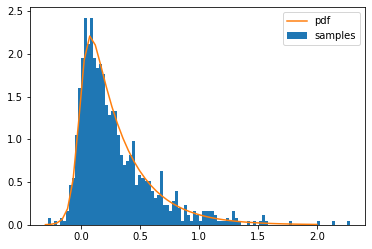

In [16]:
_, bins, _ = plt.hist(samples, bins = 100, density = True, label = 'samples')
x = np.linspace(-0.3, 2)
plt.plot(x, p2(x), label = 'pdf')
plt.legend()
plt.show()

In [17]:
from scipy.stats import laplace_asymmetric, expon

In [18]:
x = np.linspace(-0.2,1,1000)

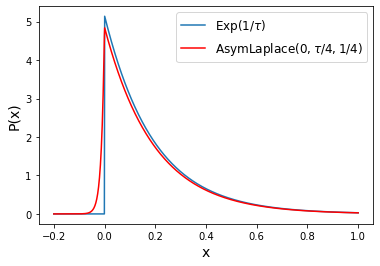

In [19]:
f = plt.figure()
plt.plot(x, expon.pdf(x, scale = 0.194), label = 'Exp$(1 / \\tau)$')
plt.plot(x, laplace_asymmetric.pdf(x, scale = 0.194/4, kappa = 0.25), color = 'r', label = 'AsymLaplace$(0, \\tau/4, 1/4)$')
plt.legend(fontsize = 12)
plt.xlabel("x", fontsize = 14)
plt.ylabel("P(x)", fontsize = 14)
f.savefig("AsymLaplacePdf.pdf", bbox_inches = 'tight')

In [22]:
hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

In [23]:
for wavelengths in [g_wavelengths, r_wavelengths, i_wavelengths, z_wavelengths]:
  print(np.min(wavelengths), np.max(wavelengths))

3903.582329180913 5659.364388292846
5335.795885899873 7094.520515610599
6718.034081959885 8361.973521621594
7940.157995219609 9440.39335807811


In [32]:
wavelengths_to_interpolate = np.linspace(3900, 9441, 10000)
times_to_interpolate = [0]

In [33]:
S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
for i, wavelength in enumerate(wavelengths_to_interpolate):
  for j, time_point in enumerate(times_to_interpolate):
    S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

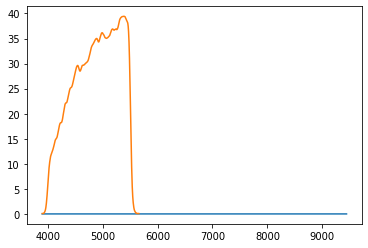

In [38]:
plt.plot(wavelengths_to_interpolate, np.squeeze(S0))
plt.plot(g_wavelengths, g_norm_throughput)

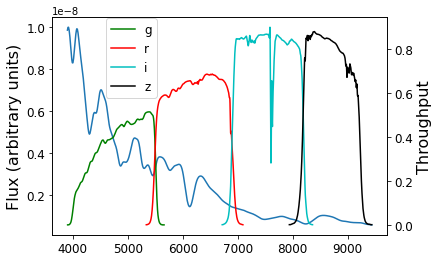

In [73]:
fig, ax1 = plt.subplots() 
ax1.plot(wavelengths_to_interpolate, np.squeeze(S0))
ax1.set_ylabel("Flux (arbitrary units)", fontsize = 16)
ax1.tick_params(axis = 'both', labelsize = 12)
# ax1.set_yticklabels(fontsize = 12)

ax2 = ax1.twinx() 
ax2.plot(g_wavelengths, g_throughput, color = 'g', label = 'g')
ax2.plot(r_wavelengths, r_throughput, color = 'r', label = 'r')
ax2.plot(i_wavelengths, i_throughput, color = 'c', label = 'i')
ax2.plot(z_wavelengths, z_throughput, color = 'k', label = 'z')
ax2.set_ylabel("Throughput", fontsize = 16)
ax2.tick_params(axis = 'y', labelsize = 12)

plt.legend(loc = (0.16, 0.63), fontsize = 12)
# plt.xticks(fontsize = 12)
fig.savefig("Throughput_plot.pdf", bbox_inches = 'tight')

In [75]:
mcmc_av_samples = np.load('/content/AT2016aj_chains_210610_135216.npy', allow_pickle=True).item()['AV']

In [76]:
xs = np.log(np.exp(25*mcmc_av_samples) - 1) /25.

(array([ 29.,  72., 155., 228., 239., 179.,  71.,  25.,   1.,   1.]),
 array([0.01149069, 0.06440827, 0.11732586, 0.17024344, 0.22316103,
        0.27607861, 0.3289962 , 0.38191378, 0.43483137, 0.48774895,
        0.54066654]),
 <a list of 10 Patch objects>)

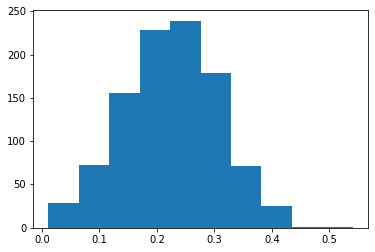

In [79]:
plt.hist(mcmc_av_samples)

(array([ 12.,  28.,  97., 186., 269., 249., 118.,  36.,   4.,   1.]),
 array([-0.04401092,  0.01445682,  0.07292456,  0.1313923 ,  0.18986004,
         0.24832778,  0.30679552,  0.36526326,  0.423731  ,  0.48219874,
         0.54066648]),
 <a list of 10 Patch objects>)

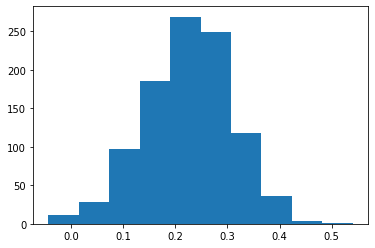

In [80]:
plt.hist(xs)